In [1]:
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import logging
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import math

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

datapath = 'data\\reduced_temperature_data.xlsx'

X_data = np.array(pd.read_excel(datapath, sheet_name = 'boundary_condition'))
temperature_data = np.transpose(np.array(pd.read_excel(datapath, sheet_name = 'temperature')))

(45, 3)
(45, 4096)


[1.4802861865405301, 0.5415617361474482, 0.26090930490118197, 0.21284025472644091, 0.19328489759468678, 0.17537482328403095, 0.1657715115155449, 0.15560421688706152, 0.1434019107172896, 0.13605555854007878, 0.05015399566280726]


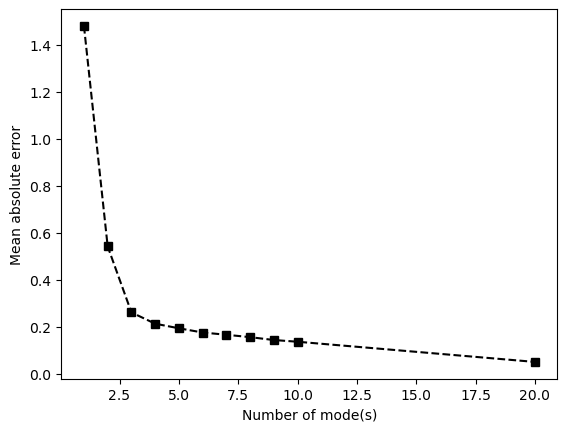

In [82]:
training_condition = (X_data[:,1] == 10)|(X_data[:,1] == 15)|(X_data[:,1] == 20)|(X_data[:,1] == 25)|(X_data[:,1] == 30)
training_row = np.where(training_condition)[0]

#train + validation
row = training_row
x_train_data = X_data[row,:]
temperature = temperature_data[row,:]

#SVD
A = temperature
U,sigma,V = np.linalg.svd(A)
S = np.zeros(np.shape(A))
for i in range(sigma.shape[0]):
    S[i,i] = sigma[i]
An = np.dot(U,S)

A_ROM = np.zeros(np.shape(A))
Modes_set = [1,2,3,4,5,6,7,8,9,10,20]

An_mode = np.zeros(np.shape(An))
V_mode = np.zeros(np.shape(V))

error = []

for Modes in Modes_set:
    An_mode[:,:Modes] = An[:,:Modes]
    V_mode[:Modes] = V[:Modes]
    A_ROM = np.dot(An_mode,V_mode)
    error.append(np.mean(abs(A_ROM-A)))
print(error)

plt.plot(Modes_set, error, 'ks--')
plt.xlabel('Number of mode(s)')
plt.ylabel('Mean absolute error')
plt.show()

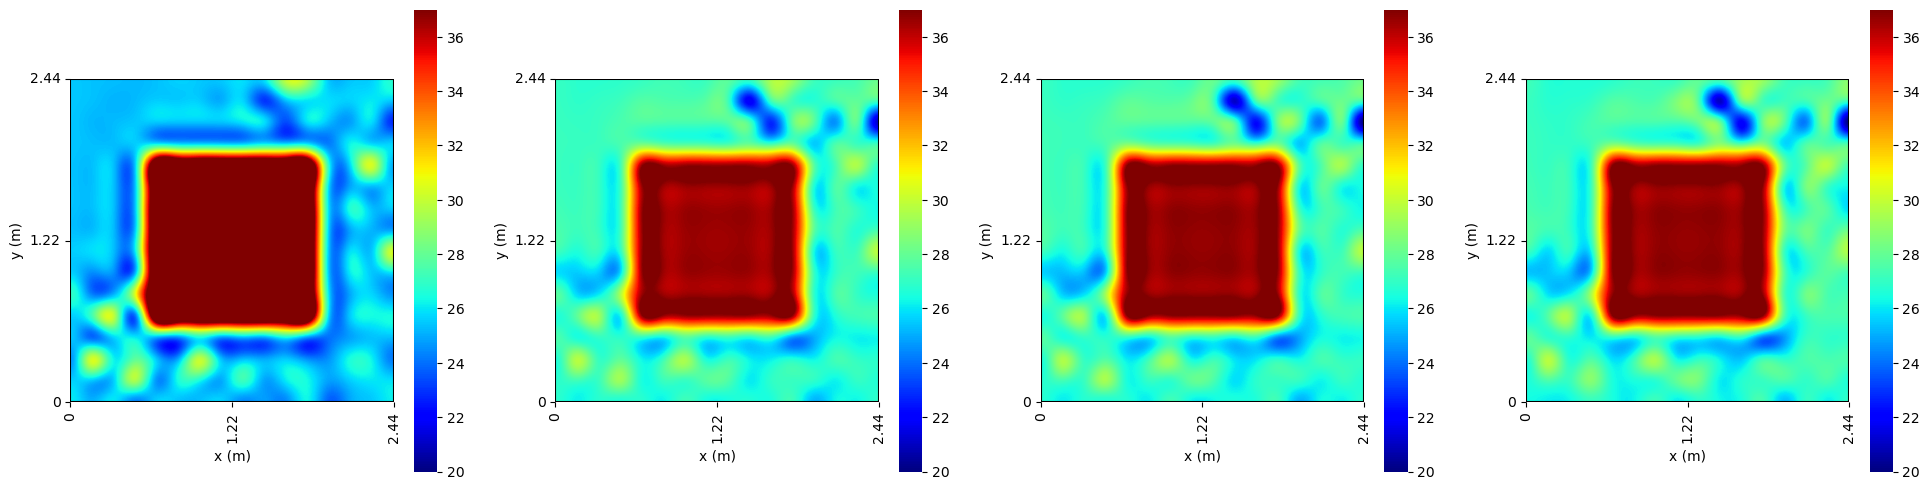

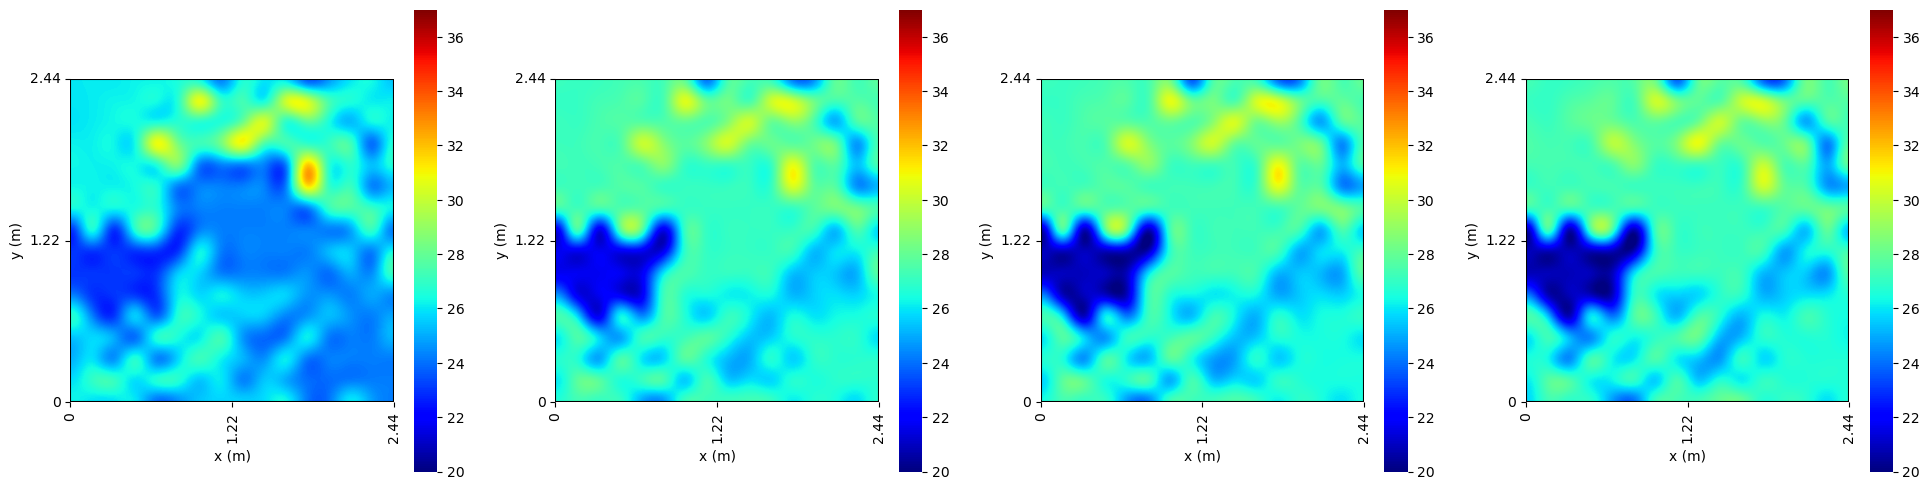

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable

An_mode = np.zeros(np.shape(An))
V_mode = np.zeros(np.shape(V))

#SVD validation
Test = A[11,:]
Coordinate = np.transpose(np.array(pd.read_excel(datapath, sheet_name = 'coordinate')))

Data_data = Coordinate

for Modes in [1,2,5]:
    An_mode[:,:Modes] = An[:,:Modes]
    V_mode[:Modes] = V[:Modes]
    A_ROM = np.dot(An_mode,V_mode)
    Pred = A_ROM[11,:]
    Data_data = np.vstack((Data_data, Pred))

Data_data = np.vstack((Data_data,Test))

for low, high in zip([0.6, 1.7], [0.7, 1.8]): 
    matching_columns = np.where((Data_data[1, :] > low) & (Data_data[1, :] < high))[0]
    filtered_data = np.transpose(np.delete(Data_data[:, matching_columns], 1, axis=0))
    
    fig = plt.figure(figsize=(24, 6)) 
    for i in range(4):
        data_dimension = int(np.sqrt(filtered_data.shape[0]))
        test_matrix = np.reshape(filtered_data[:, i+2], (data_dimension, data_dimension))
        
        zoomed_matrix = zoom(test_matrix, 100)
        
        ax = fig.add_subplot(1, 4, i+1) 
        sns.heatmap(zoomed_matrix, cmap='jet',   
                    vmin=20,  
                    vmax=37,  
                    ax=ax,
                    cbar=True,
                    cbar_kws={'shrink': 1.0})
        ax.set_aspect('equal') 
        
        
        ticks = [0, zoomed_matrix.shape[0]/2, zoomed_matrix.shape[0]-1]  
        labels = ['0', '1.22', '2.44']  
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels[::-1])  
        
    
        ax.set_xlabel('x (m)')  
        ax.set_ylabel('y (m)')  

        ax.axhline(y=0, color='k')
        ax.axhline(y=zoomed_matrix.shape[0]-1, color='k')
        ax.axvline(x=0, color='k')
        ax.axvline(x=zoomed_matrix.shape[1]-1, color='k')
    
    plt.savefig(f'my_plot_{low}.png')
    plt.show()

In [62]:
from optuna import delete_study
from optuna.exceptions import StorageInternalError
import time
from tensorflow.keras import layers
start =time.time()

training_condition = (X_data[:,1] == 10)|(X_data[:,1] == 12.5)|(X_data[:,1] == 15)|(X_data[:,1] == 17.5)|(X_data[:,1] == 20)
training_row = np.where(training_condition)[0]

#mode number
mode_num = 5

x_train_data = X_data[training_row,:]
y_train_data = An[:,:mode_num]
split = 0.8
train_size = math.ceil(np.shape(x_train_data)[0]*split)


x_train_scaled = (x_train_data - np.mean(x_train_data))/np.std(x_train_data)
y_train_scaled = (y_train_data - np.mean(y_train_data))/np.std(y_train_data)

tf.random.set_seed(1234)  # applied to achieve consistent results

#early_stop settings
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 1, 5)
    model = tf.keras.models.Sequential()
    for i in range(n_layers):
        num_hidden = trial.suggest_int('n_units_{}'.format(i), 4, 64, log=True)
        model.add(layers.Dense(num_hidden, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        dropout = trial.suggest_float('dropout_{}'.format(i), 0.1, 0.5)
        model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(mode_num))

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)       
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['mae', 'mse'])

    return model

def objective(trial):
    
    tf.keras.backend.clear_session()

    x_train = x_train_scaled[:train_size,:]
    x_valid = x_train_scaled[train_size:,:]
    y_train = y_train_scaled[:train_size,:]
    y_valid = y_train_scaled[train_size:,:]  

    model = create_model(trial)

    model.fit(x_train, y_train,
              callbacks=early_stop,
              epochs=2000,
              validation_data=(x_valid, y_valid),
              verbose=0)
    def r_squared(y_true, y_pred):
        mean = np.mean(y_true)
        total_sum_squares = np.sum((y_true - mean) ** 2)
        residual_sum_squares = np.sum((y_true - y_pred) ** 2)
        r2 = 1 - (residual_sum_squares / total_sum_squares)
        return r2
    
    score = r_squared(y_valid, model.predict(x_valid,verbose=0))
    return score

if __name__ == '__main__':
    storage_name = 'sqlite:///POD_CFD_ANN_opt.db'
    
    study_name='POD_CFD_ANN_opt'
    try:
        delete_study(storage=storage_name, study_name=study_name)
    except StorageInternalError:
        pass
    
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='maximize',
        study_name=study_name, storage=storage_name,load_if_exists=True
    )
    study.optimize(objective, n_trials=20)
    
    best_params = study.best_params
    best_value = study.best_value
    print('\n\nbest_value = '+str(best_value))
    print('best_params:')
    print(best_params)

end=time.time()
print('Running time: %s Seconds'%(end-start))

[I 2024-03-17 18:32:01,216] A new study created in RDB with name: POD_CFD_ANN_opt
[I 2024-03-17 18:32:45,960] Trial 0 finished with value: 0.20549569575705495 and parameters: {'n_layers': 5, 'n_units_0': 16, 'dropout_0': 0.20248616798843871, 'n_units_1': 17, 'dropout_1': 0.24810133509665602, 'n_units_2': 10, 'dropout_2': 0.4015082937977963, 'n_units_3': 22, 'dropout_3': 0.22121402498539455, 'n_units_4': 12, 'dropout_4': 0.2721517783563545, 'learning_rate': 1.5424399164483995e-05}. Best is trial 0 with value: 0.20549569575705495.
[I 2024-03-17 18:33:22,930] Trial 1 finished with value: 0.859688435489236 and parameters: {'n_layers': 5, 'n_units_0': 7, 'dropout_0': 0.38137311488834, 'n_units_1': 39, 'dropout_1': 0.37148720090455556, 'n_units_2': 51, 'dropout_2': 0.3084010777432775, 'n_units_3': 7, 'dropout_3': 0.4120383161927208, 'n_units_4': 16, 'dropout_4': 0.2181916884426213, 'learning_rate': 0.00013719645170499192}. Best is trial 1 with value: 0.859688435489236.
[I 2024-03-17 18:33:32



best_value = 0.9836301595705657
best_params:
{'n_layers': 3, 'n_units_0': 4, 'dropout_0': 0.46998609090687193, 'n_units_1': 4, 'dropout_1': 0.1003530707925113, 'n_units_2': 5, 'dropout_2': 0.2091586897149798, 'learning_rate': 0.09245199883238046}
Running time: 239.16745257377625 Seconds


In [65]:
start =time.time()

from tensorflow.keras.layers import Dropout

def create_model(best_params):
    model = Sequential()
    for i in range(best_params['n_layers']):
        model.add(Dense(best_params[f'n_units_{i}'], activation='relu'))
        model.add(Dropout(best_params[f'dropout_{i}']))
    model.add(Dense(mode_num))
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

test_condition = (X_data[:,1] == 22.5)|(X_data[:,1] == 25)|(X_data[:,1] == 27.5)|(X_data[:,1] == 30)
test_row = np.where(test_condition)[0]

x_train = x_train_scaled
y_train = y_train_scaled
x_test = (X_data[test_row,:] - np.mean(x_train_data))/np.std(x_train_data)
y_test = temperature_data[test_row,:]

model = create_model(best_params)
model.fit(x_train, y_train, callbacks=early_stop,epochs=2000, verbose=0)

An_pred = model.predict(x_test)*np.std(y_train_data) + np.mean(y_train_data)
y_pred = np.dot(An_pred, V[:mode_num])

NRMSE = []
for i in range(x_test.shape[0]):
    NRMSE.append((mean_squared_error(y_test[i,:], y_pred[i,:]))**0.5/(np.max(y_test[i,:])-np.min(y_test[i,:])))

MAE = []
for i in range(x_test.shape[0]):
    MAE.append(mean_absolute_error(y_test[i,:], y_pred[i,:]))

model.summary()
print(np.mean(MAE),np.std(MAE))
print(np.round(MAE,2))
print(np.mean(NRMSE))
print(np.round(NRMSE,2))

end=time.time()
print('Running time: %s Seconds'%(end-start))

1/1 [==============================] - 0s 36ms/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 40)                160       
                                                                 
 dropout_3 (Dropout)         (None, 40)                0         
                                                                 
 dense_6 (Dense)             (None, 5)                 205       
                                                                 
Total params: 365 (1.43 KB)
Trainable params: 365 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
0.858664816831101 0.4076972564505869
[0.55 0.81 1.12 1.66 0.37 0.61 1.01 1.56 0.28 0.56 0.99 1.39 0.29 0.56
 0.82 1.36 0.72 0.48 0.81 1.25]
0.0693883870737737
[0.03 0.05 0.07 0.1  0.03 0.04 0.07 0.11 0.02 0.04 0.07 0.11 0.03 0.05
 0.08 

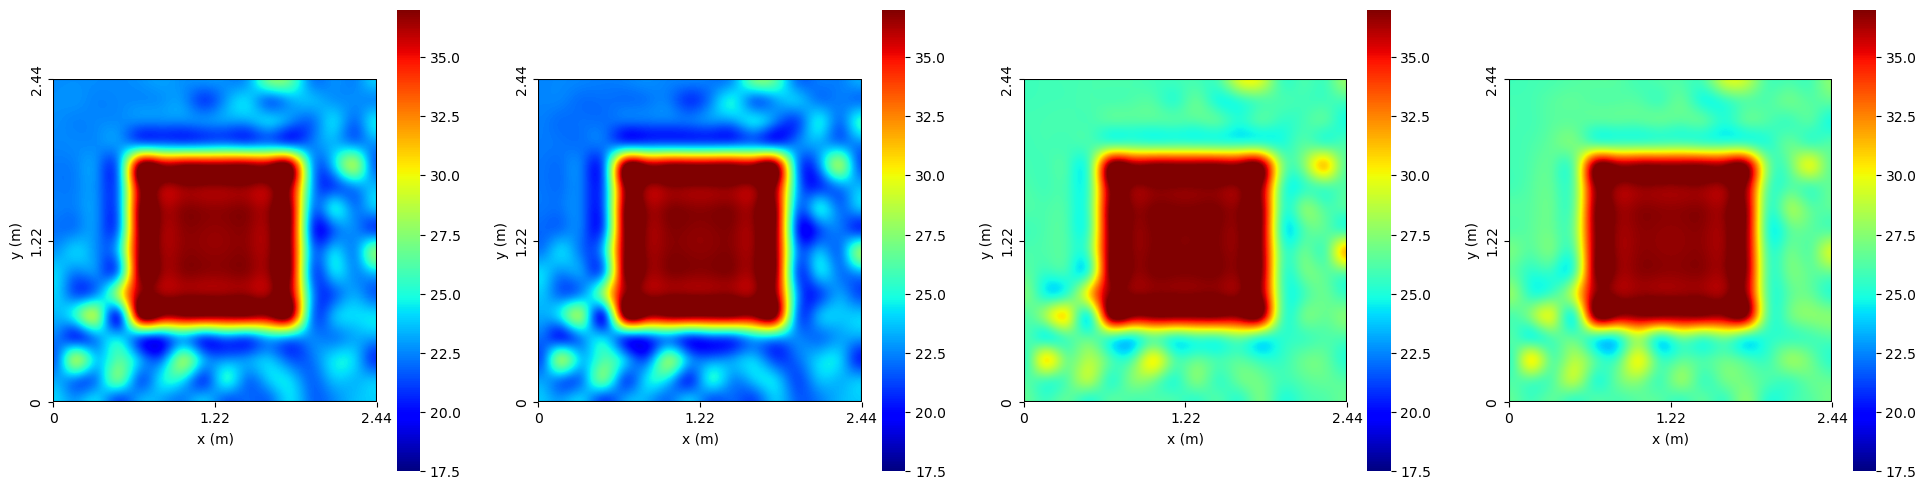

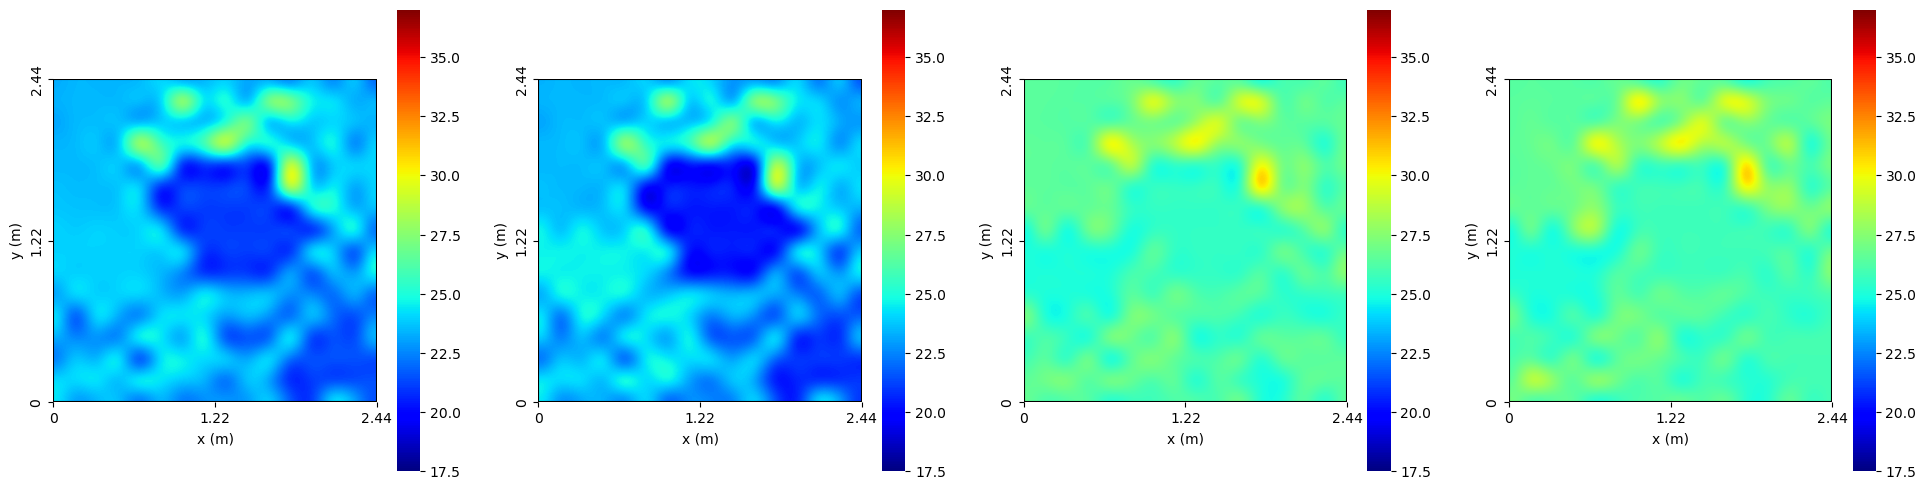

In [83]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
from matplotlib.colors import LinearSegmentedColormap 
from scipy.ndimage import zoom

df_ANN = pd.read_excel('ANN.xlsx') 
df_POD = pd.read_excel('RBF.xlsx', header=None) 
direct_ANN = np.array(df_ANN) 
direct_POD = np.array(df_POD)


#selec the comparison case
BC = 17
Test = y_test[BC,:] 
Pred = y_pred[BC,:] 
ANN_pred = direct_ANN[BC,:] 
POD_pred = direct_POD[BC,:]

Coordinate = np.transpose(np.array(pd.read_excel(datapath, sheet_name = 'coordinate'))) 
Data_data = np.vstack((Coordinate, ANN_pred, POD_pred, Pred, Test))

for low,high in zip([0.6,1.7],[0.7,1.8]): 
    matching_columns = np.where((Data_data[1,:]>low) & (Data_data[1,:]<high))[0] 
    filtered_data = np.transpose(np.delete(Data_data[:, matching_columns], 1, axis=0)
                                )

    fig = plt.figure(figsize=(24, 6))  

    for i in range(4):
        data_dimension = int(np.sqrt(filtered_data.shape[0]))
        test_matrix = np.reshape(filtered_data[:, i+2], (data_dimension, data_dimension))

        zoomed_matrix = zoom(test_matrix, 100)

        ax = fig.add_subplot(1, 4, i+1)  
        sns.heatmap(zoomed_matrix, cmap = 'jet',
                    #vmin=np.min(filtered_data[:,2:]), 
                    vmin=17.5, 
                    vmax=37,
                    #vmax=np.max(filtered_data[:,2:]),
                    ax=ax,
                    cbar=True,
                    cbar_kws={'shrink': 1.0})
        ax.set_aspect('equal') 

        ticks = [0, zoomed_matrix.shape[0]/2, zoomed_matrix.shape[0]-1]  
        labels = ['0', '1.22', '2.44']  
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels[::-1]) 

        ax.set_xlabel('x (m)')  
        ax.set_ylabel('y (m)')  

        ax.axhline(y=0, color='k')
        ax.axhline(y=zoomed_matrix.shape[0]-1, color='k')
        ax.axvline(x=0, color='k')
        ax.axvline(x=zoomed_matrix.shape[1]-1, color='k')

        ticks = [0, zoomed_matrix.shape[0]/2, zoomed_matrix.shape[0]]  
        labels = ['0', '1.22', '2.44'] 
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels(labels,rotation='horizontal')
        ax.set_yticklabels(labels[::-1],rotation='vertical')  

    plt.savefig(f'POD_vs_ANN_{low}.png')
    plt.show()

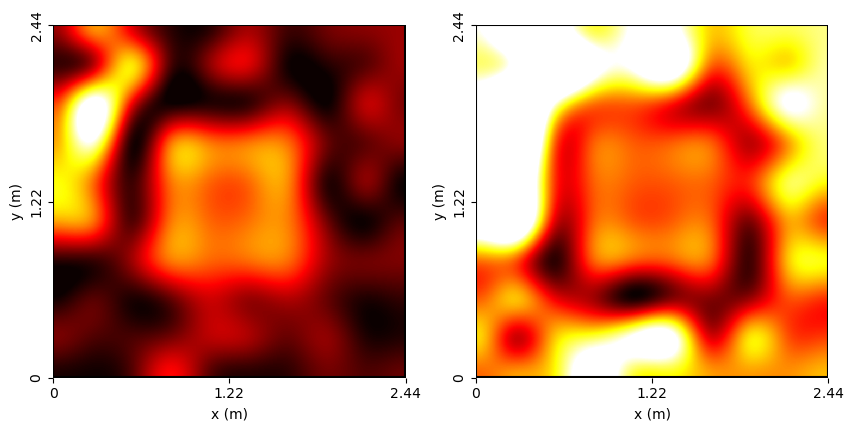

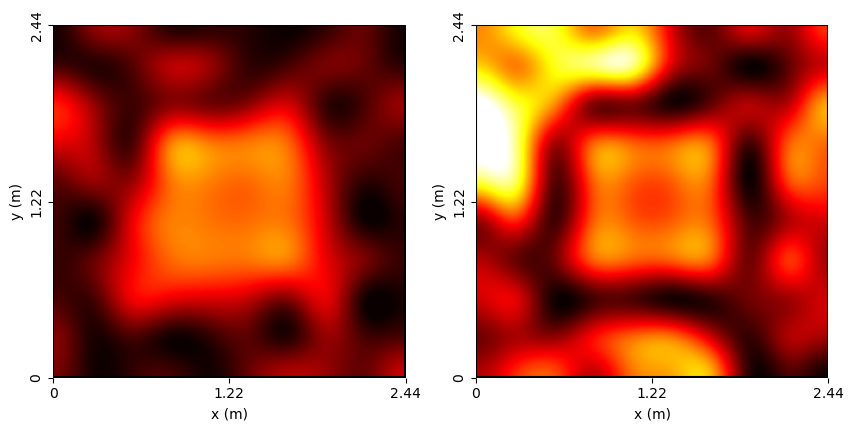

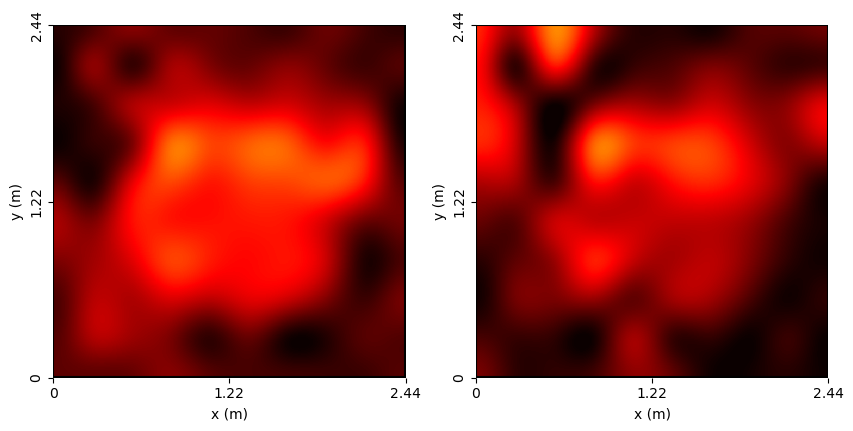

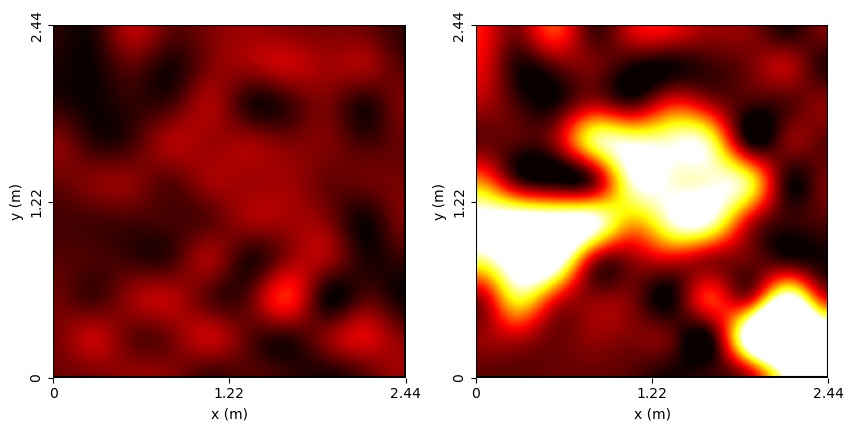

In [102]:
error_ANN = abs(ANN_pred-Test)
error_POD = abs(Pred-Test)

Data_data = np.vstack((Coordinate, error_ANN, error_POD))

for low,high in zip([0.1,0.6,1,1.8],[0.2,0.7,1.1,1.9]): 
    matching_columns = np.where((Data_data[1,:]>low) & (Data_data[1,:]<high))[0]
    filtered_data = np.transpose(np.delete(Data_data[:, matching_columns], 1, axis=0))
    
    fig = plt.figure(figsize=(10, 5)) 
    for i in range(2):
        test_matrix = np.reshape(filtered_data[:,i+2], (10, 10))

        zoomed_matrix = zoom(test_matrix, 100)
        
        ax = fig.add_subplot(1, 2, i+1)
        sns.heatmap(zoomed_matrix, cmap = 'hot',
                    #vmin=np.min(filtered_data[:,2:]), 
                    vmin=0, 
                    vmax=1,
                    #vmax=np.max(filtered_data[:,2:]),
                    ax=ax,
                    cbar=False)
        ax.set_aspect('equal') 
        
        ticks = [0, zoomed_matrix.shape[0]/2, zoomed_matrix.shape[0]-1]  
        labels = ['0', '1.22', '2.44'] 
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels[::-1])  
    
        ax.set_xlabel('x (m)')  
        ax.set_ylabel('y (m)')  

        ax.axhline(y=0, color='k')
        ax.axhline(y=zoomed_matrix.shape[0]-1, color='k')
        ax.axvline(x=0, color='k')
        ax.axvline(x=zoomed_matrix.shape[1]-1, color='k')
    
        ticks = [0, zoomed_matrix.shape[0]/2, zoomed_matrix.shape[0]]  
        labels = ['0', '1.22', '2.44']  
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels(labels,rotation='horizontal')
        ax.set_yticklabels(labels[::-1],rotation='vertical') 
    
    plt.savefig(f'Error{low}.png')
    plt.show()